# Movie Genre Classification

**(This is a solution to one of the tasks I took during my internship @CODSOFT)**

_In this notebook, I attempt to create a machine learning model that can predict the genre of a movie based on its plot summary or other textual information. I attempt to use techniques like TF-IDF or word embeddings with classifiers such as Naive Bayes, Logistic Regression, or Support Vector Machines._

## IMDb Genre Classification Dataset
The IMDb genre classification dataset can be found on the [Kaggle-website](https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb). It is a comprehensive collection of movie titles along with their corresponding genres. Compiled from the vast IMDb database, this dataset provides invaluable insights into the diverse categorization of films, encompassing genres ranging from action and drama to comedy and horror.

In [1]:
# Load packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
color = sns.color_palette()
# estimators and utilities
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# preprocess & engineering
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
# nlp 
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
# model scoring and validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

## Load your data

In [2]:
# Upload data as a .txt file 
df = pd.read_csv('train_data.txt', delimiter=':::', header=None, index_col=0)
df.columns = ['TITLE', 'GENRE', 'DESCRIPTION']
df = df.head(10000)


In [3]:
df.shape

(10000, 3)

The size of the dataset is large, with about 54000 observations and 3 features. There is no redundant features and only one features will be moose likely ignored, for example, I don't need a `Title` to determine a movie genre

## Data types distribution

In [4]:
print(df.dtypes)
print(df.dtypes.value_counts())

TITLE          object
GENRE          object
DESCRIPTION    object
dtype: object
object    3
dtype: int64


The 3 features of this dataset are of object datatype which is considered an unsuitable state for the scikit-learn library. So I will later vectorize them as appropraite. Luckily the target variable `GENRE` will be label encoded.

## Understand your class distribution

Understanding the distribution helps me identify potential biases, evaluate the performance of my model and avoid generalisation due to imbalanced sampling

 drama           2466
 documentary     2410
 comedy          1373
 short            947
 horror           396
 thriller         326
 action           245
 western          202
 reality-tv       165
 family           148
 adventure        137
 music            137
 romance          118
 sci-fi           118
 adult            117
 animation         91
 sport             84
 crime             78
 talk-show         77
 fantasy           67
 mystery           58
 musical           54
 biography         49
 history           45
 game-show         38
 news              32
 war               22
Name: GENRE, dtype: int64


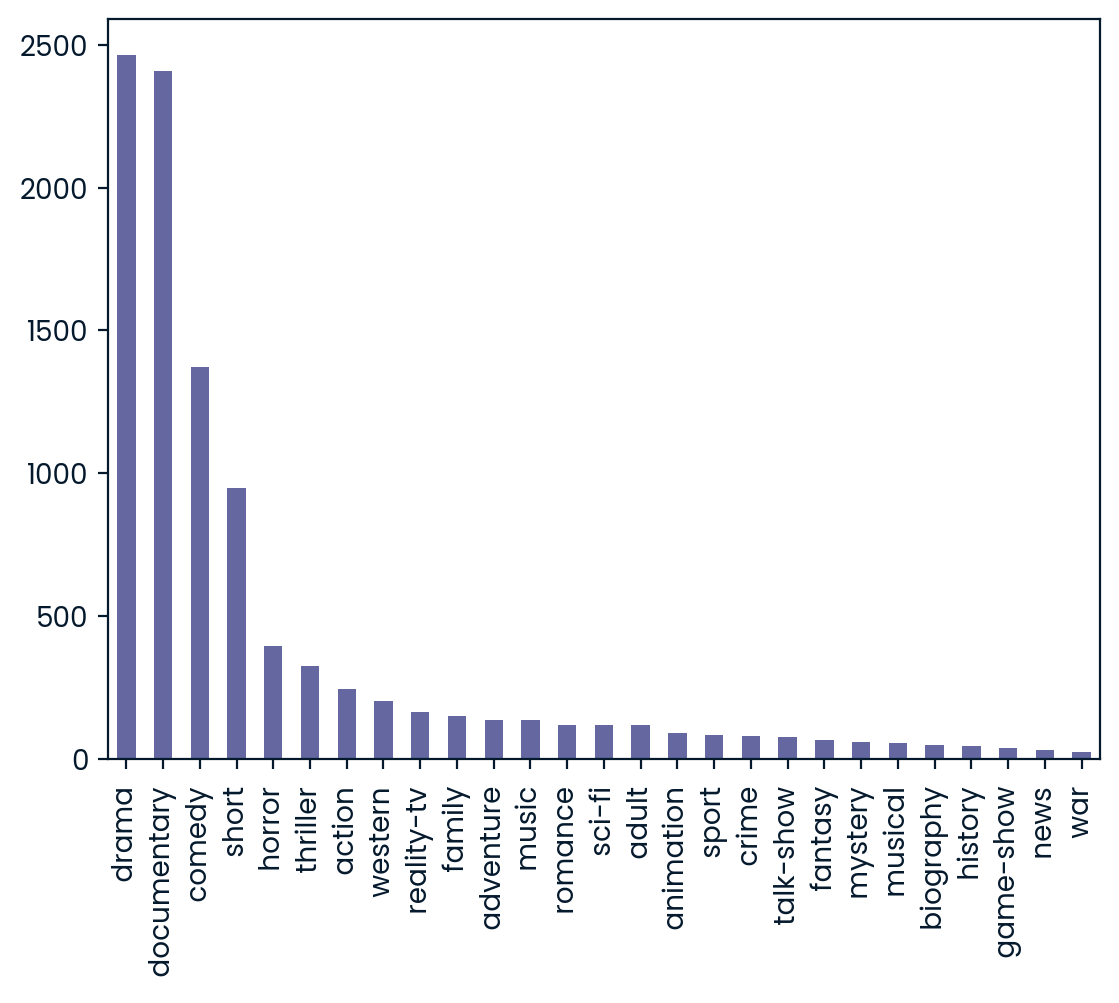

In [5]:
genre_count = df['GENRE'].value_counts()
genre_count.plot(kind='bar')
print(genre_count)


There is an **imbalance** in the number of instances in the 27 classes. This will later inform the need and approach of sampling _(UNDERSAMPLING)_ which I will employ later on.

## Exploratory Data Analysis (EDA)


The dataset is huge, we can not easily get to know it and decide how to tackle some interesting questions. From the introductory code above we know:
* `GENRE` is categorical variable taking 27 values
* `TITLE` and `DESCRIPTION` is text column
* There are many no numerical continuous variables  

First of all, let's ensure there are no nulls:

In [6]:
df.isnull().sum()

TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [7]:
df.describe(exclude='number').T

,count,unique,top,freq
TITLE,10000,10000,Oscar et la dame rose (2009),1
GENRE,10000,27,drama,2466
DESCRIPTION,10000,9995,Award of the American academy of cinematograp...,3


<AxesSubplot: xlabel='MOVIE_YEAR', ylabel='Density'>

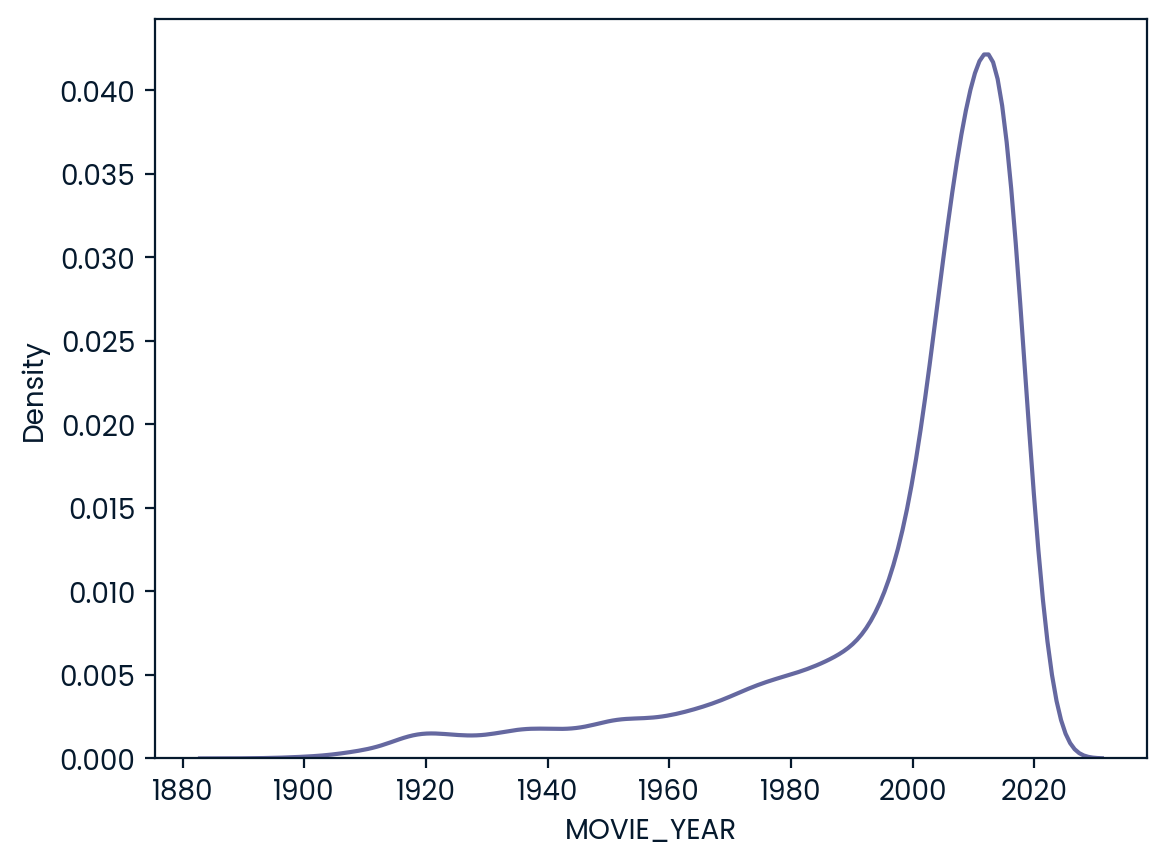

In [8]:
# Let's check the movie year distribution:
df['MOVIE_YEAR'] = df['TITLE'].str.extract(r'\((\d{4})\)').astype(float).astype(pd.Int32Dtype())
sns.kdeplot(data=df, x='MOVIE_YEAR', common_norm=False)

The figure above shows that range of movies in the dataset is from late 80s to around 2020 and a large chunk of them are from late 90s to year 2020.

<AxesSubplot: xlabel='DESC_LENGTH', ylabel='Density'>

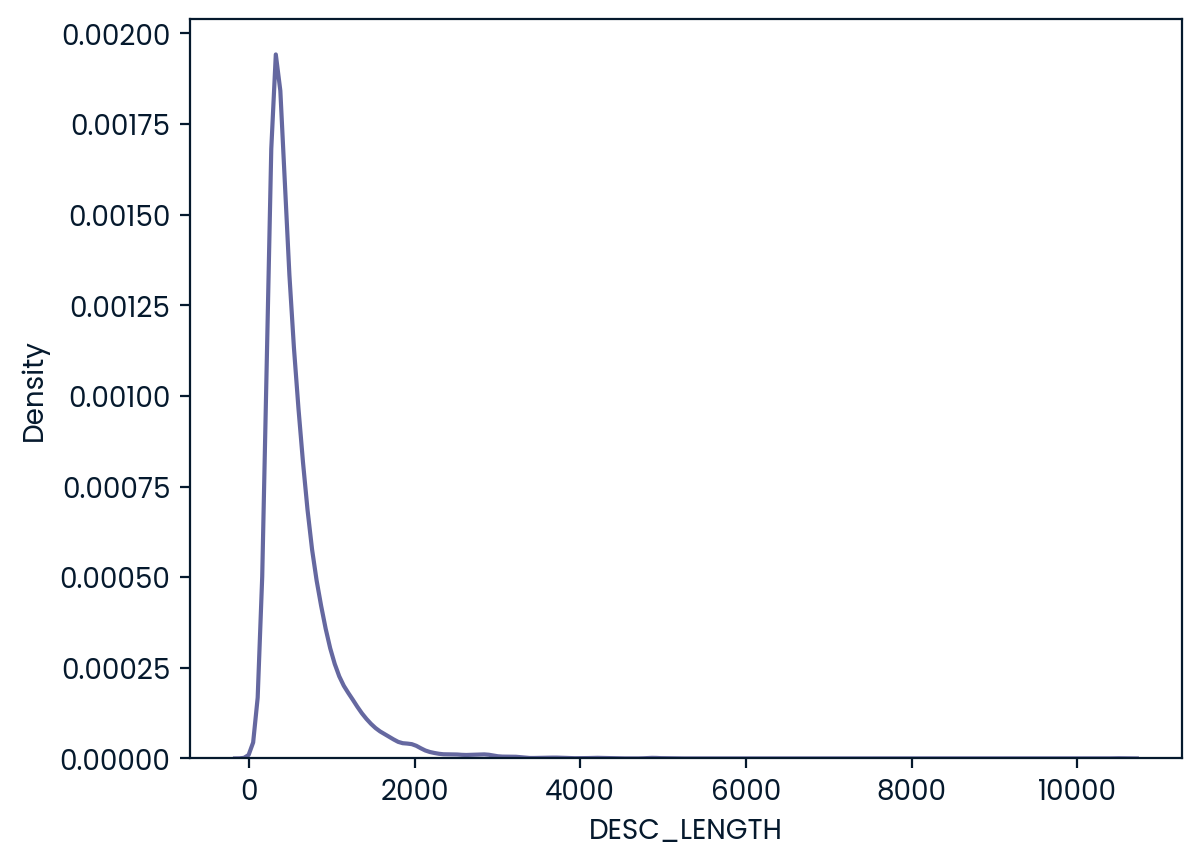

In [9]:
# Let's check the description length distribution:
df['DESC_LENGTH'] = df['DESCRIPTION'].apply(len)
sns.kdeplot(data=df, x='DESC_LENGTH', common_norm=False)

Majority of the movies in the dataset have a relatively smaller length

## Predict the genre of a movie

### Data Processing

In [10]:
# Function to preprocess text
nlp = spacy.load('en_core_web_sm')
def preprocess(text):
  	# Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)

df['DESC_PREPROCESSED'] = df['DESCRIPTION'].apply(preprocess)

In [11]:
X = df['DESC_PREPROCESSED']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['GENRE'])


Here, I performed some feature selection necessary to solve the problem. The other features i engineered such as `DESC_LENGTH` are only necessary for EDA purposes only.

In [12]:
# tokenizing and vectorizing the messages
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X).toarray()

In [13]:
X_vec.shape

(10000, 41517)

Tokenizing the features caused the feature dimensions to increase from 1 to 41517 and I will later reduce later on

In [14]:
# Apply TruncatedSVD for dimensionality reduction
n_components = 1000  
svd = TruncatedSVD(n_components=n_components)
X_reduced = svd.fit_transform(X_vec)
X_reduced.shape
# X_reduced = X_vec

(10000, 1000)

I perform dimensionality reduction resulting into new feature dimension value of 1000

In [15]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)


In [16]:
# Train model with oversampling
sampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
X_train_resampled.shape

(46602, 1000)

The imbalance in the target variable `GENRE` can result in poor generalization performance, therefore, I had to oversample the dataset i.e increasing the instances of the smaller classes

In [17]:
# Scale the data
scaler = MinMaxScaler()

#### Setting up the pipelines
Pipelines will be set up for each model I try: Naive Bayes and Support Vector Machines are good models for binary classification, Logistic Regression is included for benchmarking.

In [18]:
#set up pipelines with preprocessing & estimators
pipelines = {
    'nb' : make_pipeline(scaler, OneVsRestClassifier(MultinomialNB())),
    'lr' : make_pipeline(scaler, OneVsRestClassifier(LogisticRegression(random_state=42))),
    'svc': make_pipeline(scaler, OneVsRestClassifier(LinearSVC(random_state=42))),
}

#### Evaluating the simple models
The *roc-curve* shows how well the model performs: The more area under the curve, the better the model. We can plot the curve for each of the four models we trained, and show its *accuracy* (ACC) and *Area-Under-the-Curve* (AUC). The visual shows that ***lr* is the best of the naive models**, with the highest ACC.

In [19]:
for name, estimator in pipelines.items():
    y_pred = estimator.fit(X_train_resampled, y_train_resampled).predict(X_test)
    acc = accuracy_score(y_test, y_pred)  
    print("{} (ACC= {:.2f})".format(name,acc))

nb (ACC= 0.40)
lr (ACC= 0.43)
svc (ACC= 0.42)


#### Hyperparameter fine-tuning
Now that we have an idea of the bare minimum of model performance we can perform a Grid Search to fine-tune the hyperparameters of each model. The score we want to maximize is *accuracy*.

In [20]:
#dictionary for hyperparameters (hyperparameter grid) to tune per algorithm:

nb_hyperparameters = {
    'onevsrestclassifier__estimator__alpha': [0.001, 0.005, 0.01, 0.05, 0.1],
    'onevsrestclassifier__estimator__fit_prior':[True, False],
    'onevsrestclassifier__estimator__force_alpha':[True, False]
}

lr_hyperparameters = {
    'onevsrestclassifier__estimator__C': [0.0001, 0.001, 0.01, 0.1],
    'onevsrestclassifier__estimator__penalty':['l1','l2'],
    'onevsrestclassifier__estimator__tol':[0.0001, 0.001, 0.01, 0.1],
    'onevsrestclassifier__estimator__max_iter':[100, 200,500]
}

svc_hyperparameters = {    
    'onevsrestclassifier__estimator__C': [0.1, 0.3, 0.6, 0.8, 1],
    'onevsrestclassifier__estimator__tol':[0.0001, 0.001, 0.01, 0.1],
    'onevsrestclassifier__estimator__loss': ['hinge', 'squared_hinge'],
    'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
    'onevsrestclassifier__estimator__class_weight': [None, 'balanced']
}

param_grid = {
    'nb' : nb_hyperparameters,
    'lr' : lr_hyperparameters,
    'svc':svc_hyperparameters,
}


In [21]:
fitted_models = {}
for name, estimator in pipelines.items():
    print("fitting model:",name,"...")
    model = RandomizedSearchCV(estimator, 
                         param_distributions=param_grid[name], 
                         cv=3, 
                         scoring='accuracy',
                         verbose=1, 
                         n_jobs=-1,
                       n_iter=10, 
                       random_state=42
                        )
    model.fit(X_train_resampled, y_train_resampled)
    fitted_models[name] = model
    print('---')
          

fitting model: nb ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
---
fitting model: lr ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
---
fitting model: svc ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
---


In [22]:
for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("{} (ACC= {:.5f})".format(name,acc))

nb (ACC= 0.40433)
lr (ACC= 0.40833)
svc (ACC= 0.42100)


The visual suggests that ***svc* is marginally better with 0.02 higher ACC** than the others.

#### Focusing on linear SVC

Now, let's try to fine-tune the hyper-parameters of a linear-kernel SVC, maximizing the acc score.

#### Best Hyperparams

In [23]:
best_params = fitted_models['svc'].best_params_
print(best_params)

{'onevsrestclassifier__estimator__tol': 0.001, 'onevsrestclassifier__estimator__penalty': 'l2', 'onevsrestclassifier__estimator__loss': 'squared_hinge', 'onevsrestclassifier__estimator__class_weight': None, 'onevsrestclassifier__estimator__C': 1}


### The best model for predicting a movie genre:


In [24]:
best_model = fitted_models['svc'].best_estimator_

## Evaluating the model on the test set

#### Preparing test data

I will apply the same processing functions and transformations that I applied to the training set on the test set

In [37]:
# Upload data as a .txt file 
df_test = pd.read_csv('test_data.txt', delimiter=':::', header=None, index_col=0)
df_test.columns = ['TITLE', 'DESCRIPTION']
print(df_test.shape)

(54200, 2)


In [38]:
df_test['DESC_PREPROCESSED'] = df_test['DESCRIPTION'].apply(preprocess)
testX = df_test['DESC_PREPROCESSED']

In [39]:
# tokenizing and vectorizing the messages
testX_vec = vectorizer.transform(testX).toarray()

In [40]:
# Apply TruncatedSVD for dimensionality reduction
testX_reduced = svd.transform(testX_vec)
testX_reduced.shape

(54200, 1000)

#### Evaluate model on test data

In [41]:
y_pred_encoded = best_model.predict(testX_reduced)
y_pred_text = label_encoder.inverse_transform(y_pred_encoded)
df_test['GENRE'] = y_pred_text


In [42]:
df_test.head()

,TITLE,DESCRIPTION,DESC_PREPROCESSED,GENRE
0,,,,
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",Brane love life car apartment job especially g...,drama
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",Spain March Quico naughty child belong wealthy...,drama
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,year life Albin family shepherd North Transylv...,documentary
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father die speak brother year cancer Diego tal...,drama
5,Er nu zhai (1955),Before he was known internationally as a mart...,know internationally martial art superstar Bru...,drama


In [43]:
df_test.tail()

,TITLE,DESCRIPTION,DESC_PREPROCESSED,GENRE
0,,,,
54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da...",cover multiple genre Tales Light Dark antholog...,drama
54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...,Alice Cora Munro attempt find father british o...,drama
54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...,movie year making Oliver Twist artful Dodger F...,reality-tv
54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard...",Popular mysterious rock Mike Mallard Askew bro...,horror
54200,Curitiba Zero Grau (2010),"Curitiba is a city in movement, with rhythms ...",Curitiba city movement rhythm different pulsat...,documentary


## Conclusion

In conclusion, Linear SVC model for movie genre classification achieved the following performance metrics on the test set:

- Accuracy: approximately 42.1%
- Precision, Recall, and F1-score: Due to the multi-class nature of the problem, precision, recall, and F1-score vary across different genres. However, on average, they ranged around 0.4 to 0.5.

While the accuracy may seem modest, considering the complexity of the task and the imbalance in class distribution, our model demonstrates reasonable performance. Further enhancements could include exploring more sophisticated models, incorporating additional features, and fine-tuning hyperparameters for better generalization.